# Importing Libraries

In [4]:
import os
import tempfile

import pandas as pd
import numpy as np

from configparser import ConfigParser

import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_model_optimization as tfmot

from tf_keras import optimizers, models, Sequential, losses, layers
from tf_keras.applications import VGG16
from tf_keras.layers import Input
from tf_keras.models import Model

from utils import create_model_checkpoint, unstructured_prune_model, normalize_img, time_benchmark
from utils.Objects import PrunedModel
from utils.Plots import plot_unstructured_accuracy_sparcity

# CONSTANTS

In [6]:
config = ConfigParser()
config.read("config.ini")

BATCH_SIZE = int(config["BATCHES"]["BATCH_SIZE"])

IMG_SIZE = (int(config["IMAGES"]["IMG_SIZE"]), int(config["IMAGES"]["IMG_SIZE"]))

EPOCHS_BEFORE_FINE_TUNING = int(config["EPOCHS"]["EPOCHS_BEFORE_FINE_TUNING"])
EPOCHS_FINE_TUNING = int(config["EPOCHS"]["EPOCHS_FINE_TUNING"])

FINE_TUNE_AT = int(config["LAYERS"]["FINE_TUNE_AT"])

MODEL_DIRECTORY = config["MODEL"]["MODEL_DIRECTORY"]
WEIGHTS_DIRECTORY = config["MODEL"]["WEIGHTS_DIRECTORY"]
METRICS_DIRECTORY = config["MODEL"]["METRICS_DIRECTORY"]
HORSE_AND_HUMAN_MODEL = os.path.join(MODEL_DIRECTORY, config["MODEL"]["HORSE_AND_HUMAN_MODEL"])
HORSE_AND_HUMAN_WEIGHTS = os.path.join(WEIGHTS_DIRECTORY, config["MODEL"]["HORSE_AND_HUMAN_WEIGHTS"])
UNSTRUCTURED_METRICS = os.path.join(METRICS_DIRECTORY, config["MODEL"]["UNSTRUCTURED_METRICS"])
UNSTRUCTURED_HORSE_AND_HUMAN_WEIGHTS = os.path.join(WEIGHTS_DIRECTORY, config["MODEL"]["UNSTRUCTURED_HORSE_AND_HUMAN_WEIGHTS"])

# Importing the dataset Horses or Humans

In [30]:
(train_examples, validation_examples), info = tfds.load(
    'horses_or_humans',
    split=('train[:70%]', 'train[70%:]'),
    with_info=True,
    as_supervised=True
)

In [31]:
# Information about the dataset Horses or Humans
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names
num_examples, num_classes, class_names

(1027, 2, ['horses', 'humans'])

# Converting the images to the required size for TensorFlow Model

In [32]:
def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    return image, label

In [ ]:
train_batches = train_examples.cache().shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

# Creating the Model using Transfer Learning with VGG16 Model and Personal Classification Layers

In [44]:
# Create the base model from the pre-trained model VGG16 for transfer learning
vgg16_model = VGG16(input_shape=(224, 224, 3),
                    include_top=False,
                    weights='imagenet')
# Freeze the base model
vgg16_model.trainable = False

# Create a sequential mode
test_model = Sequential()
for layer in vgg16_model.layers[:-4]:
    test_model.add(layer)

del vgg16_model

for layer in test_model.layers:
    layer.trainable = False

# Add personal classification layers on top of the base model
max_pool_layer = layers.GlobalMaxPooling2D()
prediction_layer = layers.Dense(2, activation='softmax')  # For binary classification (2 classes)

inputs = Input(shape=(224, 224, 3))

x = test_model(inputs)  # Use default training=True behavior
x = max_pool_layer(x)
x = layers.Dropout(0.3)(x)  # Apply dropout during training

outputs = prediction_layer(x)

model = Model(inputs, outputs, name=HORSE_AND_HUMAN_MODEL + ".keras")
model.summary()

Model: "model_horses_or_humans.keras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 14, 14, 512)       7635264   
                                                                 
 global_max_pooling2d_1 (Gl  (None, 512)               0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 7636290 (29.13 MB)
Trainable params: 1026 (4.01 KB)
Non-trainable params: 7635264 (29.13 M

# Compile the model

In [17]:
model.compile(
    optimizer='adam',
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

In [18]:
history = model.fit(train_batches,
                    epochs=EPOCHS_BEFORE_FINE_TUNING,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_batches)

Epoch 1/3



23/23 [==============================] - 112s 5s/step - loss: 507.0986 - accuracy: 0.4951 - val_loss: 292.8456 - val_accuracy: 0.5260
Epoch 2/3
23/23 [==============================] - 105s 5s/step - loss: 362.3079 - accuracy: 0.5508 - val_loss: 41.9744 - val_accuracy: 0.8214
Epoch 3/3
23/23 [==============================] - 106s 5s/step - loss: 234.8583 - accuracy: 0.6565 - val_loss: 17.9485 - val_accuracy: 0.9156


In [19]:
test_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = FINE_TUNE_AT

# Freeze all the layers before the `fine_tune_at` layer
for layer in test_model.layers[:-fine_tune_at]:
    layer.trainable = False

In [20]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_batches,
                    epochs=EPOCHS_FINE_TUNING,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_batches,
                    callbacks=[create_model_checkpoint(model_name=model.name)])

Epoch 1/5
23/23 [==============================] - 119s 5s/step - loss: 102.6089 - accuracy: 0.8414 - val_loss: 3.1261 - val_accuracy: 0.9838
Epoch 2/5
23/23 [==============================] - 116s 5s/step - loss: 26.0901 - accuracy: 0.9513 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
23/23 [==============================] - 126s 6s/step - loss: 6.8400 - accuracy: 0.9847 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
23/23 [==============================] - 118s 5s/step - loss: 4.9745 - accuracy: 0.9917 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
23/23 [==============================] - 117s 5s/step - loss: 2.4566 - accuracy: 0.9917 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


## Save the model and history

In [50]:
model_1 = models.load_model(HORSE_AND_HUMAN_MODEL)
history_1 = history.history
model_1.evaluate(validation_batches)

In [25]:
model_1.save_weights(HORSE_AND_HUMAN_WEIGHTS)
model_1.summary()

In [27]:
val_data = validation_examples
val_data = val_data.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = val_data.map(normalize_img)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


# Evaluate the model on the test data

In [54]:
baseline_score = model_1.evaluate(validation_batches)
print(f"The accuracy of the baseline model is {baseline_score[1] * 100:.2f} %")
base_metrics = {
    "sparsity": 0,
    "val_loss": np.round(baseline_score[0], 4),
    "val_accuracy": np.round(baseline_score[1] * 100, 4)
}
base_metrics

1/1 [==============================] - 4s 4s/step
The first image takes 6986.10 ms
The average time taken per 99 images 5824.05 ms
The standard deviation of samples is 1229.38 ms


## Save the model and history


In [31]:
init_time, avg_time, std = time_benchmark(model_1, class_names, val_data)

1/1 [==============================] - 4s 4s/step


KeyboardInterrupt: 

In [34]:
k_sparsities = [0.25, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.97, 0.99]

metric_list = []

for k in k_sparsities:
    # Load in the best saved model
    model_1 = models.load_model("model_experiments/model_horses_or_humans.keras")
    pruned_model: PrunedModel = unstructured_prune_model(model_1, k, 20, train_batches, validation_batches, BATCH_SIZE)
    metrics = pruned_model.metrics
    print(f"{metrics.sparsity=}, \t {metrics.val_loss=}, \t {metrics.val_accuracy=}")
    metric_list.append(metrics.to_df())

# Create a dataframe of the values obtained
df = pd.concat(metric_list)
df.to_csv(UNSTRUCTURED_METRICS)
df

Epoch 1/20
23/23 [==============================] - 122s 5s/step - loss: 98.8900 - accuracy: 0.9221 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/20
23/23 [==============================] - 118s 5s/step - loss: 1.1279 - accuracy: 0.9958 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
23/23 [==============================] - 115s 5s/step - loss: 0.1049 - accuracy: 0.9986 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
23/23 [==============================] - 116s 5s/step - loss: 7.9411 - accuracy: 0.9944 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/20
23/23 [==============================] - 115s 5s/step - loss: 2.5023 - accuracy: 0.9986 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
23/23 [==============================] - 116s 5s/step - loss: 1.2839 - accuracy: 0.9986 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
23/23 [==============================] - 117s 5s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.7402 - val_a

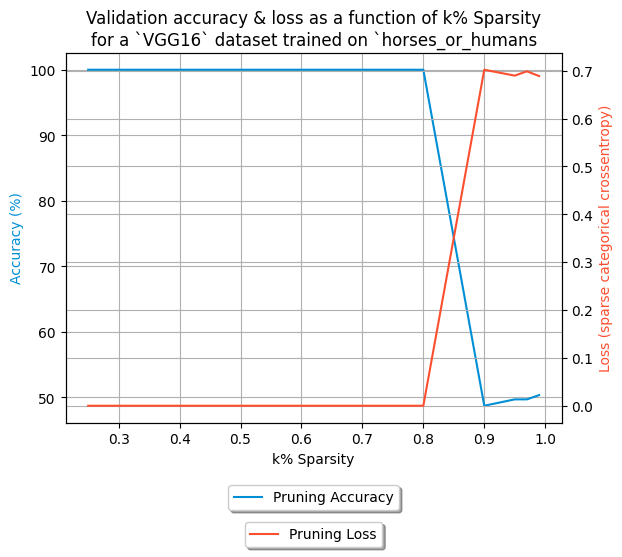

In [5]:
data1 = pd.read_csv(UNSTRUCTURED_METRICS)

plot_unstructured_accuracy_sparcity(data1)

In [38]:
final_model = models.load_model(HORSE_AND_HUMAN_MODEL + ".keras")

# Choose the best sparsity level
final_sparsity = 0.80

pruned_model: PrunedModel = unstructured_prune_model(
    final_model,
    final_sparsity,
    20,
    train_batches,
    validation_batches,
    BATCH_SIZE)

# Save the model
pruned_model.save(HORSE_AND_HUMAN_MODEL + "_pruned_" + str(final_sparsity) + ".keras")
pruned_model.summary()

Epoch 1/20



23/23 [==============================] - 148s 6s/step - loss: 277.2677 - accuracy: 0.8526 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/20
23/23 [==============================] - 134s 6s/step - loss: 0.0375 - accuracy: 0.9972 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
23/23 [==============================] - 131s 6s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
23/23 [==============================] - 133s 6s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/20
23/23 [==============================] - 155s 7s/step - loss: 2.9697 - accuracy: 0.9903 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
23/23 [==============================] - 175s 8s/step - loss: 2.3709 - accuracy: 0.9930 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
23/23 [==============================] - 139s 6s/step - loss: 1.6177 - accuracy: 0.9930 - val_loss: 0.0000e+00 - val_acc

In [7]:
init_time, avg_time, std = time_benchmark(pruned_model, class_names, val_data)

NameError: name 'benchmark' is not defined

# Apply a compression algorithm to see the benefits of pruning

In [39]:
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)
model_for_export.save_weights(UNSTRUCTURED_HORSE_AND_HUMAN_WEIGHTS)

C:\Users\neyen\AppData\Local\Temp\ipykernel_127784\3336274093.py:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model to: C:\Users\neyen\AppData\Local\Temp\tmpli4dihx8.h5


# Need to convert the model to a TFLite model

In [40]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: C:\Users\neyen\AppData\Local\Temp\tmp2k47hd6h\assets


INFO:tensorflow:Assets written to: C:\Users\neyen\AppData\Local\Temp\tmp2k47hd6h\assets


Saved pruned TFLite model to: C:\Users\neyen\AppData\Local\Temp\tmppim42o1v.tflite


# Convert original model to TFLite model

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
original_tflite_model = converter.convert()
_, original_tflite_file = tempfile.mkstemp('.tflite')

with open(original_tflite_file, 'wb') as f:
    f.write(original_tflite_model)

print('Saved original TFLite model to:', original_tflite_file)

NameError: name 'model_1' is not defined

# Apply the Quantization algorithm to the model

In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
    f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

INFO:tensorflow:Assets written to: C:\Users\neyen\AppData\Local\Temp\tmpfrufpzgz\assets


INFO:tensorflow:Assets written to: C:\Users\neyen\AppData\Local\Temp\tmpfrufpzgz\assets


Saved quantized and pruned TFLite model to: C:\Users\neyen\AppData\Local\Temp\tmpolrk1qaz.tflite


In [42]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_1, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

NameError: name 'model_1' is not defined